## Analyze PRDE Data for Coursework

Run the PRDE.py file to generate simulation data befor analysis

In [9]:
# Initial Setup:
# Import all the libraries we need

import matplotlib.pyplot as plt
import numpy as np
import csv
import math
import random
import pandas as pd
import scipy as sp
from scipy import stats
import seaborn as sns 
import statsmodels.api as sm
from scipy.stats import ttest_rel

from BSE import market_session

# The next are helper functions that you will use later, if they don't make 
# much sense now, don't worry too much about it they will become clearer later:

# Use this to plot trades of a single experiment
def plot_trades(trial_id):
    prices_fname = trial_id + '_tape.csv'
    x = np.empty(0)
    y = np.empty(0)
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            time = float(row[1])
            price = float(row[2])
            x = np.append(x,time)
            y = np.append(y,price)

    plt.plot(x, y, 'x', color='black') 
    
# Use this to run an experiment n times and plot all trades
def n_runs_plot_trades(n, trial_id, start_time, end_time, traders_spec, order_sched):
    x = np.empty(0)
    y = np.empty(0)

    for i in range(n):
        trialId = trial_id + '_' + str(i)
        tdump = open(trialId + '_avg_balance.csv','w')

        market_session(trialId, start_time, end_time, traders_spec, order_sched, tdump, True, False)
        
        tdump.close()

        with open(trialId + '_tape.csv', newline='') as csvfile:
            reader = csv.reader(csvfile)
            for row in reader:
                time = float(row[1])
                price = float(row[2])
                x = np.append(x,time)
                y = np.append(y,price)

    plt.plot(x, y, 'x', color='black');

# !!! Don't use on it's own   
def getorderprice(i, sched, n, mode):
    pmin = min(sched[0][0], sched[0][1])
    pmax = max(sched[0][0], sched[0][1])
    prange = pmax - pmin
    stepsize = prange / (n - 1)
    halfstep = round(stepsize / 2.0)

    if mode == 'fixed':
        orderprice = pmin + int(i * stepsize)
    elif mode == 'jittered':
        orderprice = pmin + int(i * stepsize) + random.randint(-halfstep, halfstep)
    elif mode == 'random':
        if len(sched) > 1:
            # more than one schedule: choose one equiprobably
            s = random.randint(0, len(sched) - 1)
            pmin = min(sched[s][0], sched[s][1])
            pmax = max(sched[s][0], sched[s][1])
        orderprice = random.randint(pmin, pmax)
    return orderprice    

# !!! Don't use on it's own
def make_supply_demand_plot(bids, asks):
    # total volume up to current order
    volS = 0
    volB = 0

    fig, ax = plt.subplots()
    plt.ylabel('Price')
    plt.xlabel('Quantity')
    
    pr = 0
    for b in bids:
        if pr != 0:
            # vertical line
            ax.plot([volB,volB], [pr,b], 'r-')
        # horizontal lines
        line, = ax.plot([volB,volB+1], [b,b], 'r-')
        volB += 1
        pr = b
    if bids:
        line.set_label('Demand')
        
    pr = 0
    for s in asks:
        if pr != 0:
            # vertical line
            ax.plot([volS,volS], [pr,s], 'b-')
        # horizontal lines
        line, = ax.plot([volS,volS+1], [s,s], 'b-')
        volS += 1
        pr = s
    if asks:
        line.set_label('Supply')
        
    if bids or asks:
        plt.legend()
    plt.show()

# Use this to plot supply and demand curves from supply and demand ranges and stepmode
def plot_sup_dem(seller_num, sup_ranges, buyer_num, dem_ranges, stepmode):
    asks = []
    for s in range(seller_num):
        asks.append(getorderprice(s, sup_ranges, seller_num, stepmode))
    asks.sort()
    bids = []
    for b in range(buyer_num):
        bids.append(getorderprice(b, dem_ranges, buyer_num, stepmode))
    bids.sort()
    bids.reverse()
    
    make_supply_demand_plot(bids, asks) 

# plot sorted trades, useful is some situations - won't be used in this worksheet
def in_order_plot(trial_id):
    prices_fname = trial_id + '_tape.csv'
    y = np.empty(0)
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            price = float(row[2])
            y = np.append(y,price)
    y = np.sort(y)
    x = list(range(len(y)))

    plt.plot(x, y, 'x', color='black')   

# plot offset function
def plot_offset_fn(offset_fn, total_time_seconds):   
    x = list(range(total_time_seconds))
    offsets = []
    for i in range(total_time_seconds):
        offsets.append(offset_fn(i))
    plt.plot(x, offsets, 'x', color='black')  

In [2]:
range1 = (50, 100) #, schedule_offsetfn)
range2 = (150, 200) #, schedule_offsetfn)
range3 = (220, 280) #, schedule_offsetfn)

sup_range = [range1, range2, range3]
dem_range = sup_range

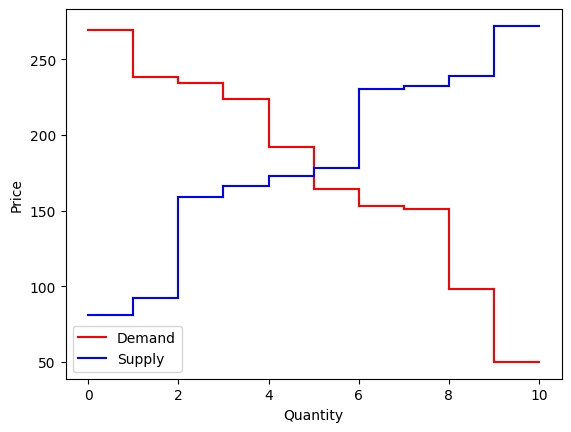

In [4]:
plot_sup_dem(10, sup_range, 10, dem_range, 'random')

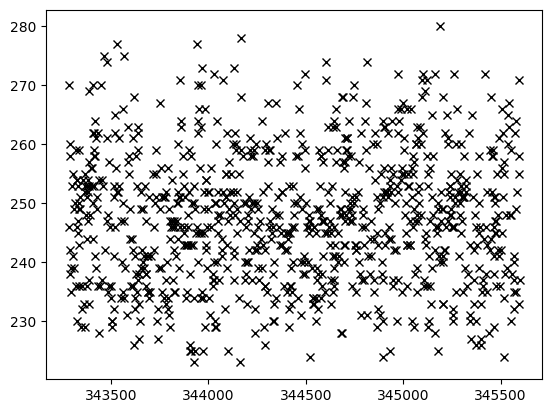

In [3]:
plot_trades('k04_F0.80_d04_01')

In [104]:
def moving_average(pps, time):

    moving_averages = list()
    
    for i in range(len(pps)-time+1):
        pps1 = pps[i : i + time]
        moving_avg = round(sum(pps1) / time, 2)
        moving_averages.append(moving_avg)

    return moving_averages

In [108]:
def generate_pps(name):
    df = pd.read_csv(name, header = None, usecols=[1,5], dtype=float)

    time = df[1]
    pps = []
    if df[1][0] == 0:
        pps.append(0)
    else:
        pps.append(df[5][0]/df[1][0])

    for i in range(df.shape[0]-1):

        if (df[1][i+1]-df[1][i]==0):
            pps.append(pps[i])
        else:
            pps.append((df[5][i+1]-df[5][i])/(df[1][i+1]-df[1][i]))


    # plt.plot(pps)
    npps=list()
    npps = moving_average(pps, 3*3600)
    
    print(np.mean(pps))
    print(np.std(pps))
    
    return npps

In [109]:
pps1 = generate_pps('k04_F1.70_d04_01_avg_balance.csv')
pps2 = generate_pps('k04_F0.70_d04_01_avg_balance.csv')
pps3 = generate_pps('k06_F1.10_d04_01_avg_balance.csv')
pps4 = generate_pps('k04_F0.80_d04_01_avg_balance.csv')

15.332782437309023
11.683537061788497
15.29093830891579
11.60870841032675
15.249795507081112
11.574537361522287
14.6984192298257
11.615071883110799


In [124]:
pps=[]
for i in np.arange(0.1, 2.0, 0.10):
    trial_id = 'k%02d_F%2.2f_d%02d_%02d' % (i, 5, 4, 1)+'_avg_balance.csv'
    print(trial_id)
    pps.append([1,2])
    print(pps)

k00_F5.00_d04_01_avg_balance.csv
[[1, 2]]
k00_F5.00_d04_01_avg_balance.csv
[[1, 2], [1, 2]]
k00_F5.00_d04_01_avg_balance.csv
[[1, 2], [1, 2], [1, 2]]
k00_F5.00_d04_01_avg_balance.csv
[[1, 2], [1, 2], [1, 2], [1, 2]]
k00_F5.00_d04_01_avg_balance.csv
[[1, 2], [1, 2], [1, 2], [1, 2], [1, 2]]
k00_F5.00_d04_01_avg_balance.csv
[[1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2]]
k00_F5.00_d04_01_avg_balance.csv
[[1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2]]
k00_F5.00_d04_01_avg_balance.csv
[[1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2]]
k00_F5.00_d04_01_avg_balance.csv
[[1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2]]
k01_F5.00_d04_01_avg_balance.csv
[[1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2]]
k01_F5.00_d04_01_avg_balance.csv
[[1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2]]
k01_F5.00_d04_01_avg_balance.csv
[[1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], 

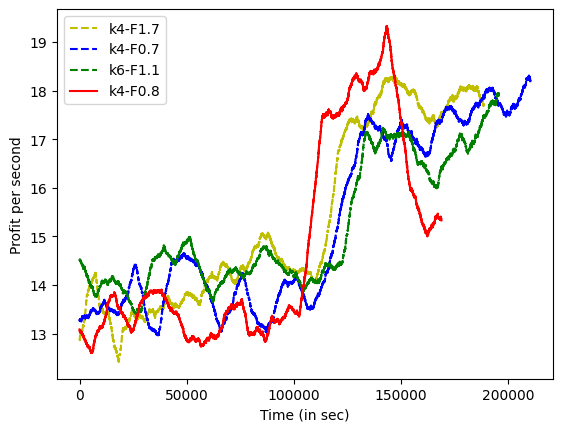

In [110]:
    fig, ax = plt.subplots()
    plt.ylabel('Profit per second')
    plt.xlabel('Time (in sec)') 

    line, = ax.plot(pps1, 'y--')  
    line.set_label('k4--F1.7')

    line, = ax.plot(pps2,'b--')
    line.set_label('k4--F0.7')
    
    line, = ax.plot(pps3,'g--')
    line.set_label('k6--F1.1')
    
    line, = ax.plot(pps4,'r-')
    line.set_label('k4--F0.8')


    plt.legend()
    plt.show() 

In [32]:
trial_id = 'k%02d_F%2.2f_d%02d_%02d' % (4, 0.3, 4, 1)
df = pd.read_csv(trial_id+'_avg_balance.csv', header = None, usecols=[1,5])
df

,1,5
0,3,19
1,4,43
2,4,64
3,6,71
4,7,95
...,...,...
225606,345597,4978386
225607,345599,4978395
225608,345599,4978438
225609,345599,4978448


In [45]:
def generate_avg_pps(name):
    df = pd.read_csv(name, header = None, usecols=[1,5], dtype=float)

    time = df[1]
    pps = []
    if df[1][0] == 0:
        pps.append(0)
    else:
        pps.append(df[5][0]/df[1][0])

    for i in range(df.shape[0]-1):

        if (df[1][i+1]-df[1][i]==0):
            pps.append(pps[i])
        else:
            pps.append((df[5][i+1]-df[5][i])/(df[1][i+1]-df[1][i]))

    
    print(np.mean(pps))
    
    return np.mean(pps)

### Generate avg_pps

**if there is a avg_pps.csv, you need not run this block!**

In [63]:

# # avg_pps = pd.DataFrame(columns=['k4', 'k5', 'k6'], index=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9])
# avg_pps = pd.DataFrame()

# for F in np.arange(0.1, 2.0, 0.10):
#     k = 4
#     F = round(F, 2)
    
#     trial_id = 'k%02d_F%2.2f_d%02d_%02d' % (k, F, 4, 1)+'_avg_balance.csv'

#     avg_pps.loc[F, 'k'+str(k)] = generate_avg_pps(trial_id)

# for F in np.arange(0.1, 2.0, 0.10):
#     k = 5
#     F = round(F, 2)
    
#     trial_id = 'k%02d_F%2.2f_d%02d_%02d' % (k, F, 4, 1)+'_avg_balance.csv'

#     avg_pps.loc[F, 'k'+str(k)] = generate_avg_pps(trial_id)
    
# for F in np.arange(0.1, 1.5, 0.10):
#     k = 6
#     F = round(F, 2)
    
#     trial_id = 'k%02d_F%2.2f_d%02d_%02d' % (k, F, 4, 1)+'_avg_balance.csv'

#     avg_pps.loc[F, 'k'+str(k)] = generate_avg_pps(trial_id)

# avg_pps.to_csv('avg_pps.csv')

### read avg_pps.csv

In [65]:
avg_pps = pd.read_csv('avg_pps.csv', index_col=[0])
avg_pps

,k4,k5,k6
0.1,14.913300,14.700695,14.282090
0.2,14.283451,14.696741,14.802968
0.3,15.032728,14.932955,14.819529
0.4,15.182597,14.618734,13.939234
0.5,14.570499,14.311783,14.746467
0.6,14.594006,14.870715,14.825667
0.7,15.290938,14.806330,14.100661
0.8,14.698419,14.802063,14.711057
0.9,14.784970,13.978707,14.586545
1.0,14.907208,14.803244,14.251349


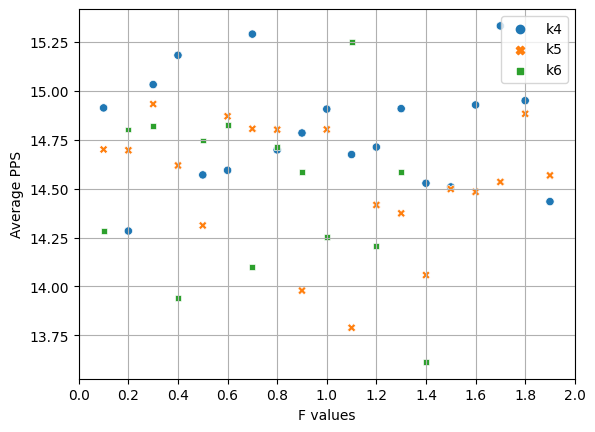

In [70]:
fig = sns.scatterplot(data=avg_pps)
fig.set(xlabel='F values')
fig.set(ylabel='Average PPS')
plt.xticks( [0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
plt.grid()

### different F values

[Text(0.5, 0, 'K_value'), Text(0, 0.5, 'Average PPS')]

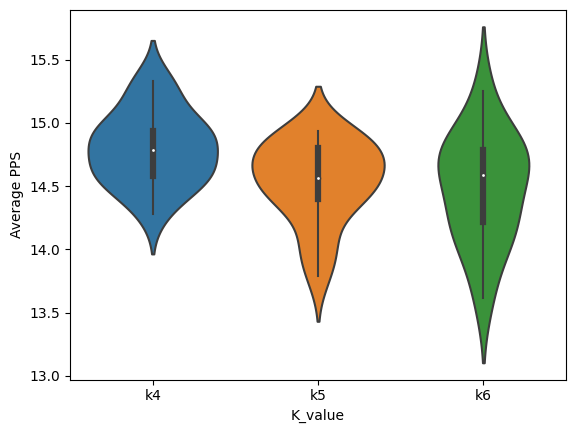

In [77]:
violin_fig = sns.violinplot(data=avg_pps)
violin_fig.set(xlabel='K_value', ylabel='Average PPS')

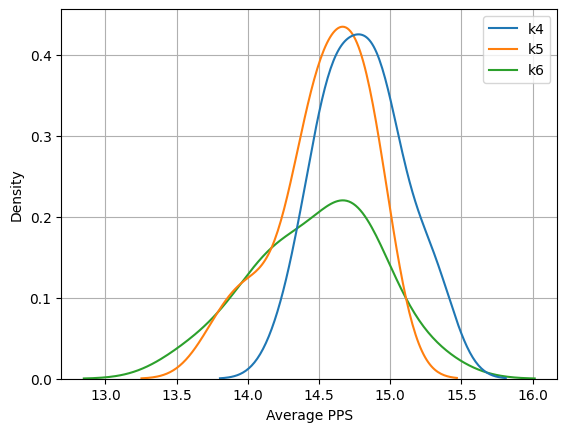

In [75]:
kde_fig = sns.kdeplot(data=avg_pps)
kde_fig.set(xlabel='Average PPS')
plt.grid()

[Text(0.5, 0, 'Distributions of results for each value of F')]

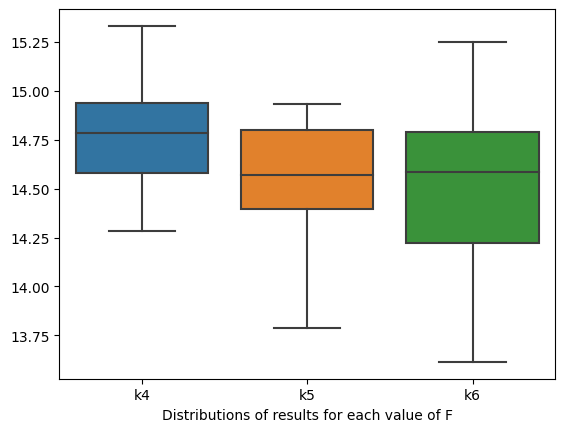

In [82]:
box_plot = sns.boxplot(avg_pps)
box_plot.set(xlabel='Distributions of results for each value of F')


### Different F values

[Text(0.5, 0, 'F values')]

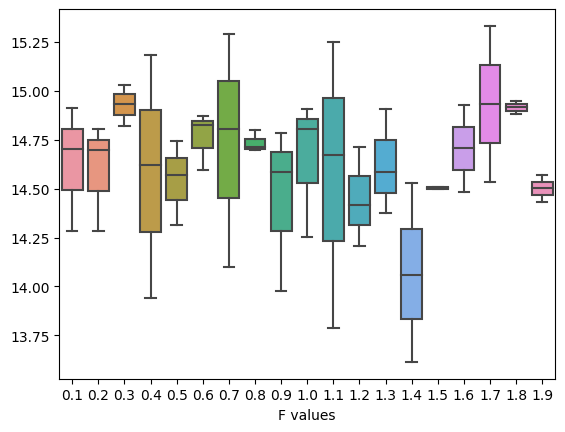

In [85]:
box_plot = sns.boxplot(avg_pps.transpose())
box_plot.set(xlabel='F values')

[Text(0.5, 0, 'F_value'), Text(0, 0.5, 'Average PPS')]

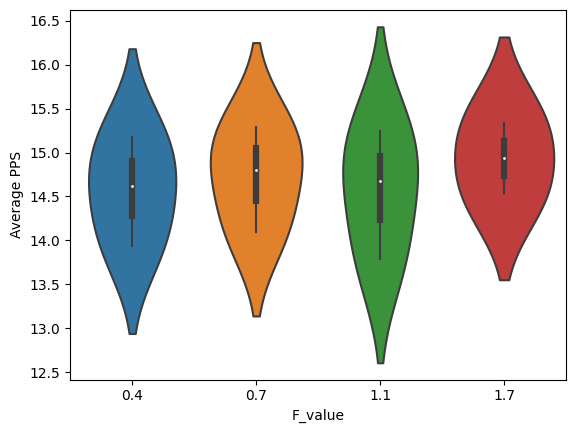

In [103]:
violin_fig = sns.violinplot(data=avg_pps.loc[[0.4,0.7,1.1,1.7]].transpose())
violin_fig.set(xlabel='F_value', ylabel='Average PPS')

### run indivial case trials

In [148]:
from BSE import market_session

import os

def run_prde(n_days, k, F,trials):
    # set up common parameters for all market sessions
    start_time = 0.0
    end_time = 60.0 * 60.0 * 24.0 * n_days
    duration = end_time - start_time

    # define traders
    sellers_spec = [('PRDE', 10, {
        'k': k,
        's_min': -1.0,
        's_max': +1.0,
        'F': F
    })]
    buyers_spec = sellers_spec
    traders_spec = {'sellers': sellers_spec, 'buyers': buyers_spec}

    range1 = (50, 100)
    range2 = (150, 200)
    range3 = (220, 280) 

    supply_schedule = [{
        'from': start_time,
        'to': start_time + duration / 3,
        'ranges': [range1],
        'stepmode': 'fixed'
    }, {
        'from': start_time + duration / 3,
        'to': start_time + 2 * duration / 3,
        'ranges': [range2],
        'stepmode': 'fixed'
    }, {
        'from': start_time + 2 * duration / 3,
        'to': end_time,
        'ranges': [range3],
        'stepmode': 'fixed'
    }]
    demand_schedule = supply_schedule

    order_interval = 5
    order_sched = {
        'sup': supply_schedule,
        'dem': demand_schedule,
        'interval': order_interval,
        'timemode': 'periodic'
    }

    verbose = True

    # n_trials is how many trials (i.e. market sessions) to run in total
    n_trials = trials

    # n_recorded is how many trials (i.e. market sessions) to write full data-files for
    n_trials_recorded = 0
    tdump = open(os.path.join('individual_data', 'k%02d_F%2.2f_' % (k, F) + 'avg_balance.csv'), 'w')

    trial = 1

    while trial < (n_trials + 1):

        trial_id = 'bse_i%02d_%04d' % (order_interval, trial)

        if trial > n_trials_recorded:
            dump_all = False
        else:
            dump_all = True

        market_session(trial_id, start_time, end_time, traders_spec,
                       order_sched, tdump, dump_all, verbose)

        tdump.flush()
        trial = trial + 1

    tdump.close()

In [149]:
# run_prde(1/24, 4, 0.8, 40)

# run_prde(1/24, 4, 1.7, 40)
# run_prde(1/24, 4, 0.7, 40)
# run_prde(1/24, 6, 1.1, 40)

B00: PRDE active_strat=[0]:
[0]: s=+0.848406, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.245798, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.482430, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.323990, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=+0.469474, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.167301, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.060836, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.103484, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=+0.774389, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.756317, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.831458, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.395099, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=-0.971724, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.089239, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.391433, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=+0.472266, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.557755, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.909008, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.199583, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.328907, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.420562, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.943190, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.992849, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.109938, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.902815, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.744663, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.260075, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=+0.381141, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.867857, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.538483, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=+0.423166, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.401244, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.793332, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.902451, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=+0.232943, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.791008, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.550438, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.709643, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.960408, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.401678, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.935390, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.773722, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=-0.481200, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.353923, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.329752, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=+0.235472, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.250858, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.770561, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.789050, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=+0.950925, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.699248, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.095558, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.704407, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.677238, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.040751, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.821190, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.525568, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=+0.253863, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.304119, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.530604, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=-0.885999, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.252225, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.540168, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.743401, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.749709, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.730566, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.232390, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.979791, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=+0.957789, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.899212, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.813071, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.965856, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=+0.766468, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.986127, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.676401, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=+0.654625, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.350514, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.352211, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.845615, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=+0.526117, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.698333, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.796668, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.170454, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.447006, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.545791, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.464354, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.187433, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=-0.018395, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.931946, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.906927, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=-0.402264, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.334413, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.881592, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.743502, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=+0.630648, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.363283, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.738235, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.722329, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=+0.077679, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.769882, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.315746, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.078155, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=-0.672545, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.581511, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.250892, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=+0.029208, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.472521, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.301616, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.549733, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.399638, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.942920, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.982424, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.895863, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.941743, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.942576, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.246493, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.888047, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=+0.515586, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.450096, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.370783, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=-0.604919, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.024818, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.187706, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.967875, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.950761, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.074178, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.464168, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.990310, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.610755, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.189964, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.874724, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.292769, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=+0.226299, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.985314, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.061681, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=+0.848622, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.744879, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.524328, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.203497, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.199864, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.147055, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.164407, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.548486, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.047822, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.964363, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.194564, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.216615, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=-0.791115, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.418300, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.422209, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=-0.040504, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.932042, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.640232, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.439362, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=+0.645116, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.991338, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.731094, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.543017, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=+0.742215, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.054694, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.487931, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.477245, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=-0.473043, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.282663, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.709486, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=+0.869151, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.730430, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.658030, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.704669, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=+0.426484, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.017155, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.232062, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.820265, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.509614, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.124410, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.576182, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.203333, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=-0.331256, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.500060, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.042601, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=+0.243025, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.880637, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.531681, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.900157, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=+0.668050, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.966183, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.603613, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.998214, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.992180, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.056974, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.749092, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.153416, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=-0.645197, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.091846, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.332706, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=+0.029381, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.054228, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.336215, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.354349, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.051701, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.555604, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.744615, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.153905, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=+0.103769, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.034933, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.095825, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.353346, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=+0.261150, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.648633, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.001871, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=+0.050105, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.830238, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.756360, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.382840, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=+0.789084, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.090211, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.708317, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.085269, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.574287, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.611825, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.435404, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.479270, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=+0.511640, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.319557, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.548138, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=-0.345782, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.890984, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.641872, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.235285, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=+0.137142, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.054596, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.313339, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.958695, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.506135, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.543842, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.119888, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.897537, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=-0.079154, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.606598, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.996755, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=+0.359925, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.518809, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.153391, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.266333, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=+0.045376, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.089143, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.953543, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.767246, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=+0.260143, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.094611, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.864526, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.586029, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=+0.411130, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.327607, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.832485, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=-0.016599, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.235917, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.172910, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.997270, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.786340, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.511925, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.925266, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.840589, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.176684, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.736262, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.950490, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.093266, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=+0.856028, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.476765, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.484876, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=-0.616304, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.954013, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.894638, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.785930, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.756277, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.895991, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.274036, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.977004, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.023343, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.517843, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.889431, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.604965, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=-0.542019, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.243301, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.443369, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=+0.852453, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.356225, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.433325, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.820669, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=+0.683066, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.952021, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.659258, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.021939, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.023551, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.346792, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.761154, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.653231, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=-0.458796, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.986184, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.489654, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=-0.048198, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.912740, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.441736, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.106362, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=+0.473404, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.993612, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.293031, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.120401, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.714363, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.097111, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.135642, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.079159, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=-0.587265, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.896925, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.495491, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=-0.901541, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.323904, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.084895, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.037715, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.071200, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.242569, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.231008, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.806716, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=+0.258069, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.736489, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.274821, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.978860, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=+0.998274, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.829851, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.169590, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=+0.763386, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.959598, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.252748, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.338337, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=+0.300494, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.620534, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.233470, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.350510, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.634956, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.440450, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.446128, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.333788, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=+0.345040, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.743089, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.431942, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=+0.432821, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.847652, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.638253, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.982143, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.790520, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.450041, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.221048, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.055047, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=+0.429047, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.729960, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.411977, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.701301, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=+0.065554, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.909410, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.192211, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=+0.209014, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.940590, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.442361, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.742654, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.353063, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.206790, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.188889, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.069871, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=+0.362678, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.502439, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.411913, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.696917, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=+0.339734, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.261417, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.267084, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=+0.515697, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.317851, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.745153, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.639266, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.682581, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.539078, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.817833, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.949554, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.434618, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.651097, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.926026, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.875858, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=+0.580775, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.433993, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.772995, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=-0.058694, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.349250, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.865170, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.319591, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.737985, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.049626, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.332092, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.898108, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=+0.678375, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.699218, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.196559, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.394897, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=+0.120959, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.145191, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.268831, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=-0.187078, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.952661, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.098591, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.780237, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=+0.686044, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.796169, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.729607, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.534697, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=+0.825743, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.453457, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.427725, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.680505, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=-0.993354, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.291516, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.934529, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=-0.555174, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.742087, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.963460, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.680550, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=+0.073413, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.908293, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.009364, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.207351, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.480509, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.547273, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.457998, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.934496, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=-0.293403, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.299477, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.328094, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=+0.397510, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.798930, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.737938, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.973369, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.696259, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.266470, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.864209, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.277579, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.641551, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.981099, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.269316, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.870895, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=+0.242877, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.344664, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.607281, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=+0.479533, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.323122, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.861346, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.770711, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.845463, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.415468, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.806269, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.815243, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.092884, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.111685, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.813738, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.921874, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=-0.571146, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.713706, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.652800, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=+0.010698, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.349204, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.837572, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.633692, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=+0.040346, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.994579, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.574613, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.339801, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=+0.895563, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.118205, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.149192, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.633044, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=-0.886109, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.213685, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.561640, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=-0.165499, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.169099, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.868428, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.723816, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=+0.207899, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.425489, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.531661, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.970223, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=+0.988575, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.571722, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.237264, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.679716, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=+0.034869, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.337816, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.391157, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=+0.529478, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.358695, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.880662, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.102628, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=+0.088477, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.303692, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.096438, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.378512, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.855159, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.089179, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.979323, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.358122, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=+0.704360, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.662869, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.752163, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=-0.647867, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.552257, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.240497, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.157171, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=+0.828831, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.784323, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.162483, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.884176, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.800071, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.580303, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.734024, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.291515, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=+0.254418, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.296643, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.138825, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=+0.762582, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.260127, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.952190, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.486855, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.127304, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.688801, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.751491, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.363357, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=+0.704681, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.548190, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.768862, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.222998, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=-0.381557, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.196944, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.209491, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=-0.885910, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.327852, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.718958, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.386561, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.226815, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.627092, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.059372, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.765834, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.263732, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.269465, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.098469, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.619688, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=-0.329923, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.984397, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.817214, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=-0.074279, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.596974, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.500861, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.729588, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.871601, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.536597, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.684320, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.813653, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.597598, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.268946, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.297852, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.182679, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=-0.142691, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.057157, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.667928, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=-0.661385, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.912206, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.920111, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.379473, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=+0.807430, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.763713, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.849195, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.541015, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.629646, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.067788, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.031997, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.127352, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=-0.708598, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.456277, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.490364, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=+0.694392, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.616119, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.895865, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.571821, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.561292, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.509922, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.688975, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.293552, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=+0.129080, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.139228, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.630089, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.606255, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=+0.583822, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.408009, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.942217, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=-0.004414, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.974043, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.620464, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.323464, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.701217, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.451572, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.081556, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.561481, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.266961, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.362078, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.412980, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.879815, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=-0.550664, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.014819, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.088716, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=+0.460951, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.294847, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.184712, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.162860, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=+0.941926, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.492551, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.080894, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.410692, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=+0.094290, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.303798, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.261637, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.400735, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=-0.792147, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.674685, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.519831, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=-0.592558, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.401883, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.004890, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.198206, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.885783, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.833821, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.548255, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.152652, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.597530, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.406029, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.747892, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.809626, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=+0.605272, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.885806, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.523390, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=+0.237875, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.591052, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.521301, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.256009, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=+0.799003, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.520767, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.389288, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.633863, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.187998, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.088061, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.368403, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.074843, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=+0.852695, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.033636, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.881733, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=-0.012634, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.463267, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.900182, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.381315, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.844959, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.566697, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.392479, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.910132, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.612159, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.781111, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.511343, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.164700, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=+0.966192, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.341148, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.757965, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=+0.619811, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.971735, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.574905, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.547580, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.682674, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.233018, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.378005, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.032173, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.014749, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.514262, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.673523, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.686533, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=-0.457795, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.960264, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.632045, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=-0.555321, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.159951, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.000297, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.299650, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=+0.216030, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.620151, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.400079, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.662278, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.670572, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.442707, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.388427, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.962089, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=-0.205091, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.729888, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.433381, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=-0.256922, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.497664, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.773404, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.531251, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.074378, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.671542, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.013822, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.562009, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.197574, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.465976, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.076161, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.243620, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=-0.104922, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.438876, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.206849, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=-0.219319, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.778008, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.494462, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.133527, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=+0.223472, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.251601, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.886495, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.039087, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.803020, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.949551, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.757123, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.928518, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=-0.091095, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.609370, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.392277, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=-0.937579, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.627474, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.741158, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.089939, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.821939, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.632633, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.931660, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.043161, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.523748, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.492213, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.202722, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.083252, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=-0.344215, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.265241, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.747099, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=-0.132199, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.194252, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.497698, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.917290, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=+0.453929, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.288911, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.969293, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.134784, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=+0.229625, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.448863, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.542367, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.091517, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=+0.214287, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.859784, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.915864, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=+0.083556, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.075375, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.285925, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.842741, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.422784, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.491119, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.255767, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.409363, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=+0.357978, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.543966, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.854299, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.216657, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=-0.847982, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.714711, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.482899, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=-0.309563, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.855331, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.559713, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.008932, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=+0.323788, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.624391, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.058852, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.261881, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.558994, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.411667, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.623596, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.576313, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=+0.937179, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.088780, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.605988, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=+0.407537, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.730174, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.671756, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.336099, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.911238, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.110665, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.414643, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.323459, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.212192, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.540877, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.334120, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.863754, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=+0.991077, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.596891, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.528379, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=-0.267291, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.979604, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.942876, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.289929, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=+0.091631, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.184000, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.004152, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.025966, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.328052, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.068019, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.961035, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.136507, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=+0.836277, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.125654, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.430262, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=+0.251828, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.670391, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.950345, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.689420, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=+0.781322, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.212997, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.384891, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.274158, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.731091, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.604789, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.462549, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.498267, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=+0.156104, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.052935, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.827245, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=-0.156737, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.532330, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.272137, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.072242, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.545927, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.762467, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.723518, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.352793, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=+0.389766, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.324461, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.630716, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.820761, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=+0.787376, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.999171, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.195903, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=+0.087792, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.156343, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.100158, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.930564, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.484849, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.546126, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.265768, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.896868, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.210231, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.976307, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.577462, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.922970, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=-0.217559, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.609078, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.621780, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=+0.477876, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.669541, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.676135, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.189968, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.237276, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.324517, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.043127, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.540898, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.467093, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.131553, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.964682, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.781075, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=-0.800055, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.911961, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.420252, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=+0.842963, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.076326, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.761134, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.167084, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=+0.674194, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.002629, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.692830, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.150414, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=+0.613714, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.299861, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.343069, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.525634, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=+0.943665, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.495342, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.100881, start=0.000000, $=0.000000, pps=0.0000

B00: PRDE active_strat=[0]:
[0]: s=-0.037973, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.005668, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.118879, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.256607, start=0.000000, $=0.000000, pps=0.000000
[4]: s=-0.022715, start=0.000000, $=0.000000, pps=0.000000
[5]: s=-0.508945, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.782197, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.453045, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.599534, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.567675, start=0.000000, $=0.000000, pps=0.000000
[4]: s=-0.188076, start=0.000000, $=0.000000, pps=0.000000
[5]: s=+0.343448, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=+0.803761, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.045785, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.979653, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.573659, start=0.0

B00: PRDE active_strat=[0]:
[0]: s=+0.504682, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.566554, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.289107, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.346078, start=0.000000, $=0.000000, pps=0.000000
[4]: s=+0.695757, start=0.000000, $=0.000000, pps=0.000000
[5]: s=-0.470531, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.072082, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.021948, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.209499, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.265835, start=0.000000, $=0.000000, pps=0.000000
[4]: s=-0.276243, start=0.000000, $=0.000000, pps=0.000000
[5]: s=+0.877896, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=+0.907628, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.400623, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.372377, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.727936, start=0.0

B00: PRDE active_strat=[0]:
[0]: s=+0.806836, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.338437, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.148945, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.920223, start=0.000000, $=0.000000, pps=0.000000
[4]: s=-0.192131, start=0.000000, $=0.000000, pps=0.000000
[5]: s=-0.359761, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.055590, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.027661, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.079072, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.314361, start=0.000000, $=0.000000, pps=0.000000
[4]: s=+0.860859, start=0.000000, $=0.000000, pps=0.000000
[5]: s=+0.286319, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.032966, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.084385, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.522693, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.921741, start=0.0

B00: PRDE active_strat=[0]:
[0]: s=+0.909886, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.770563, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.810273, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.259351, start=0.000000, $=0.000000, pps=0.000000
[4]: s=+0.550826, start=0.000000, $=0.000000, pps=0.000000
[5]: s=-0.089160, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.446327, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.968666, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.002604, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.980082, start=0.000000, $=0.000000, pps=0.000000
[4]: s=+0.476392, start=0.000000, $=0.000000, pps=0.000000
[5]: s=-0.815815, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.409413, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.750772, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.507083, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.262517, start=0.0

B00: PRDE active_strat=[0]:
[0]: s=+0.534076, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.613233, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.153268, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.292511, start=0.000000, $=0.000000, pps=0.000000
[4]: s=-0.698539, start=0.000000, $=0.000000, pps=0.000000
[5]: s=+0.314847, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.473802, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.967042, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.316449, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.586900, start=0.000000, $=0.000000, pps=0.000000
[4]: s=+0.720782, start=0.000000, $=0.000000, pps=0.000000
[5]: s=-0.535831, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.419471, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.673313, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.959101, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.554409, start=0.0

B00: PRDE active_strat=[0]:
[0]: s=-0.002145, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.777016, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.033764, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.867169, start=0.000000, $=0.000000, pps=0.000000
[4]: s=-0.498290, start=0.000000, $=0.000000, pps=0.000000
[5]: s=-0.130159, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.115465, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.179497, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.964407, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.756573, start=0.000000, $=0.000000, pps=0.000000
[4]: s=-0.341127, start=0.000000, $=0.000000, pps=0.000000
[5]: s=+0.376453, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.531147, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.529728, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.724562, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.505241, start=0.0

B00: PRDE active_strat=[0]:
[0]: s=-0.186781, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.936818, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.401739, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.509666, start=0.000000, $=0.000000, pps=0.000000
[4]: s=-0.883543, start=0.000000, $=0.000000, pps=0.000000
[5]: s=+0.272352, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.213682, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.000636, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.360435, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.671484, start=0.000000, $=0.000000, pps=0.000000
[4]: s=-0.635402, start=0.000000, $=0.000000, pps=0.000000
[5]: s=+0.012473, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=+0.516269, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.642406, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.648643, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.696466, start=0.0

B00: PRDE active_strat=[0]:
[0]: s=-0.549124, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.361979, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.705436, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.102478, start=0.000000, $=0.000000, pps=0.000000
[4]: s=-0.912573, start=0.000000, $=0.000000, pps=0.000000
[5]: s=-0.001088, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=+0.096099, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.178835, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.376610, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.007794, start=0.000000, $=0.000000, pps=0.000000
[4]: s=+0.630101, start=0.000000, $=0.000000, pps=0.000000
[5]: s=-0.815706, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.185590, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.123996, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.567838, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.025306, start=0.0

B00: PRDE active_strat=[0]:
[0]: s=-0.331471, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.613414, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.724456, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.036087, start=0.000000, $=0.000000, pps=0.000000
[4]: s=+0.060908, start=0.000000, $=0.000000, pps=0.000000
[5]: s=+0.911794, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.002119, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.161420, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.974704, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.338119, start=0.000000, $=0.000000, pps=0.000000
[4]: s=-0.641336, start=0.000000, $=0.000000, pps=0.000000
[5]: s=+0.327808, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=+0.019038, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.933996, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.629858, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.327832, start=0.0

B00: PRDE active_strat=[0]:
[0]: s=-0.537049, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.433139, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.875836, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.314491, start=0.000000, $=0.000000, pps=0.000000
[4]: s=-0.061886, start=0.000000, $=0.000000, pps=0.000000
[5]: s=+0.090426, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.185302, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.609631, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.124766, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.042713, start=0.000000, $=0.000000, pps=0.000000
[4]: s=+0.418169, start=0.000000, $=0.000000, pps=0.000000
[5]: s=+0.511421, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=+0.217591, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.844674, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.097633, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.303419, start=0.0

B00: PRDE active_strat=[0]:
[0]: s=-0.871490, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.652762, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.425922, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.037838, start=0.000000, $=0.000000, pps=0.000000
[4]: s=-0.654139, start=0.000000, $=0.000000, pps=0.000000
[5]: s=+0.979604, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.623533, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.171251, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.655547, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.172840, start=0.000000, $=0.000000, pps=0.000000
[4]: s=-0.377622, start=0.000000, $=0.000000, pps=0.000000
[5]: s=+0.531537, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.076034, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.602180, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.153382, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.944906, start=0.0

B00: PRDE active_strat=[0]:
[0]: s=+0.478410, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.073640, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.876579, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.951135, start=0.000000, $=0.000000, pps=0.000000
[4]: s=+0.297851, start=0.000000, $=0.000000, pps=0.000000
[5]: s=-0.126434, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.320947, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.480035, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.560668, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.483960, start=0.000000, $=0.000000, pps=0.000000
[4]: s=+0.540937, start=0.000000, $=0.000000, pps=0.000000
[5]: s=+0.083104, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.328027, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.400764, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.542351, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.395745, start=0.0

B00: PRDE active_strat=[0]:
[0]: s=-0.438359, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.433424, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.028355, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.043321, start=0.000000, $=0.000000, pps=0.000000
[4]: s=-0.090326, start=0.000000, $=0.000000, pps=0.000000
[5]: s=+0.010938, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=+0.991335, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.908591, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.618740, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.203789, start=0.000000, $=0.000000, pps=0.000000
[4]: s=+0.466767, start=0.000000, $=0.000000, pps=0.000000
[5]: s=+0.023512, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=+0.713593, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.611489, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.141107, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.900461, start=0.0

B00: PRDE active_strat=[0]:
[0]: s=+0.289417, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.757079, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.892658, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.709056, start=0.000000, $=0.000000, pps=0.000000
[4]: s=-0.859927, start=0.000000, $=0.000000, pps=0.000000
[5]: s=+0.357495, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.714926, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.385766, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.295166, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.784460, start=0.000000, $=0.000000, pps=0.000000
[4]: s=+0.395598, start=0.000000, $=0.000000, pps=0.000000
[5]: s=-0.975514, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=+0.156215, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.965635, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.231378, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.198791, start=0.0

B00: PRDE active_strat=[0]:
[0]: s=+0.642301, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.951403, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.053694, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.054101, start=0.000000, $=0.000000, pps=0.000000
[4]: s=+0.674762, start=0.000000, $=0.000000, pps=0.000000
[5]: s=-0.665697, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.338451, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.153279, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.433807, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.257902, start=0.000000, $=0.000000, pps=0.000000
[4]: s=-0.808288, start=0.000000, $=0.000000, pps=0.000000
[5]: s=+0.137395, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.930997, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.257844, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.186492, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.906431, start=0.0

B00: PRDE active_strat=[0]:
[0]: s=+0.705666, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.103316, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.600436, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.008019, start=0.000000, $=0.000000, pps=0.000000
[4]: s=+0.723518, start=0.000000, $=0.000000, pps=0.000000
[5]: s=-0.067256, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.192915, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.235254, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.765322, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.044359, start=0.000000, $=0.000000, pps=0.000000
[4]: s=+0.606578, start=0.000000, $=0.000000, pps=0.000000
[5]: s=+0.419567, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=+0.014740, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.169241, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.280502, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.578986, start=0.0

B00: PRDE active_strat=[0]:
[0]: s=+0.071124, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.782067, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.195764, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.182848, start=0.000000, $=0.000000, pps=0.000000
[4]: s=-0.636229, start=0.000000, $=0.000000, pps=0.000000
[5]: s=+0.384559, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.317217, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.958986, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.424474, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.315375, start=0.000000, $=0.000000, pps=0.000000
[4]: s=+0.674096, start=0.000000, $=0.000000, pps=0.000000
[5]: s=+0.987879, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=+0.190370, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.871669, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.735652, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.495859, start=0.0

B00: PRDE active_strat=[0]:
[0]: s=-0.789272, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.677080, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.276696, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.079845, start=0.000000, $=0.000000, pps=0.000000
[4]: s=+0.877775, start=0.000000, $=0.000000, pps=0.000000
[5]: s=-0.396383, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.401593, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.298540, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.183689, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.914492, start=0.000000, $=0.000000, pps=0.000000
[4]: s=+0.193990, start=0.000000, $=0.000000, pps=0.000000
[5]: s=+0.089218, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.046194, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.243645, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.833293, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.146618, start=0.0

B00: PRDE active_strat=[0]:
[0]: s=+0.391670, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.899027, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.381480, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.113327, start=0.000000, $=0.000000, pps=0.000000
[4]: s=-0.322282, start=0.000000, $=0.000000, pps=0.000000
[5]: s=+0.274927, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=+0.771298, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.559363, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.140935, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.637621, start=0.000000, $=0.000000, pps=0.000000
[4]: s=+0.279304, start=0.000000, $=0.000000, pps=0.000000
[5]: s=+0.402035, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.381148, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.537957, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.859322, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.881369, start=0.0

B00: PRDE active_strat=[0]:
[0]: s=+0.188206, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.408319, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.648554, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.239841, start=0.000000, $=0.000000, pps=0.000000
[4]: s=-0.151315, start=0.000000, $=0.000000, pps=0.000000
[5]: s=+0.923566, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=+0.852049, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.851013, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.567190, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.762442, start=0.000000, $=0.000000, pps=0.000000
[4]: s=-0.870512, start=0.000000, $=0.000000, pps=0.000000
[5]: s=-0.213896, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=+0.632355, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.939418, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.367826, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.939687, start=0.0

In [163]:
# k4F17 = pd.read_csv('individual_data/k04_F1.70_avg_balance.csv',header = None, usecols=[7], dtype=float)
# k4F07 = pd.read_csv('individual_data/k04_F0.70_avg_balance.csv',header = None, usecols=[7], dtype=float)
# k6F11 = pd.read_csv('individual_data/k06_F1.10_avg_balance.csv',header = None, usecols=[7], dtype=float)


# k4F08 = pd.read_csv('individual_data/k04_F0.80_avg_balance.csv',header = None, usecols=[7], dtype=float)

k4F17 = pd.read_csv('k04_F1.70_d04_01_avg_balance.csv',header = None, usecols=[7], dtype=float)
k4F07 = pd.read_csv('k04_F0.70_d04_01_avg_balance.csv',header = None, usecols=[7], dtype=float)
k6F11 = pd.read_csv('k06_F1.10_d04_01_avg_balance.csv',header = None, usecols=[7], dtype=float)


k4F08 = pd.read_csv('k04_F0.80_d04_01_avg_balance.csv',header = None, usecols=[7], dtype=float)

In [173]:
def test_normal_distribution(profits, name):
    print("Using Shapiro-Wilk test to test the null hypothesis " +
          "that the data was drawn from a normal distribution:")

    statistic, pvalue = stats.shapiro(profits)
    if pvalue < 0.05:
        print("We can reject the null hypothesis (p=" +
              "{:.2f}".format(pvalue) + "). Therefore," + name +
              "  is not normally distributed.")
    else:
        print("We cannot reject the null hypothesis (p=" +
              "{:.2f}".format(pvalue) + "). Therefore," + name +
              " is normally distributed.")

# def test_normal_distribution(df, name):
#     norm_a = (df - df.mean())/df.std()
#     print("Condition a. " + str(stats.kstest(norm_a,'norm')))

In [187]:
print(k4F17.iloc[-1000:].describe())
print(k4F07.iloc[-1000:].describe())
print(k6F11.iloc[-1000:].describe())
print(k4F08.iloc[-1000:].describe()) 

                   7
count    1000.000000
mean   236666.208650
std       389.272077
min    235995.700000
25%    236329.612500
50%    236671.675000
75%    237002.712500
max    237332.850000
                   7
count    1000.000000
mean   248046.561400
std       333.289766
min    247466.300000
25%    247759.787500
50%    248054.000000
75%    248334.100000
max    248620.950000
                   7
count    1000.000000
mean   241523.361650
std       372.547491
min    240882.900000
25%    241196.900000
50%    241521.100000
75%    241841.025000
max    242173.200000
                   7
count    1000.000000
mean   214697.392250
std       407.660169
min    213996.850000
25%    214345.787500
50%    214694.300000
75%    215052.000000
max    215396.500000


In [178]:
test_normal_distribution(k4F17.iloc[-1000:], 'k4F1.7')
test_normal_distribution(k4F07.iloc[-1000:], 'k4F0.7')
test_normal_distribution(k6F11.iloc[-1000:], 'k6F1.1')


test_normal_distribution(k4F08.iloc[-1000:], 'k4F0.8')

Using Shapiro-Wilk test to test the null hypothesis that the data was drawn from a normal distribution:
We can reject the null hypothesis (p=0.00). Therefore,k4F1.7  is not normally distributed.
Using Shapiro-Wilk test to test the null hypothesis that the data was drawn from a normal distribution:
We can reject the null hypothesis (p=0.00). Therefore,k4F0.7  is not normally distributed.
Using Shapiro-Wilk test to test the null hypothesis that the data was drawn from a normal distribution:
We can reject the null hypothesis (p=0.00). Therefore,k6F1.1  is not normally distributed.
Using Shapiro-Wilk test to test the null hypothesis that the data was drawn from a normal distribution:
We can reject the null hypothesis (p=0.00). Therefore,k4F0.8  is not normally distributed.


In [167]:
# def t_test(profit1, profit2):
#     statistic, p = stats.ttest_ind(profit1,
#                                    profit2,
#                                    equal_var=False)

#     if p < 0.05:
#         print("T-test: " + 'p_value' +
#               " < 0.05). " + "Reject null hypothesis that 2 independent " +
#               "samples have identical average (expected) values")
#     else:
#         print("T-test: " + 'p_value' +
#               " > 0.05). " +
#               "Cannot reject null hypothesis that 2 independent " +
#               "samples have identical average (expected) values")

In [184]:
import scipy
scipy.stats.mannwhitneyu (k4F17.iloc[-1000:], k4F08.iloc[-1000:]) 

MannwhitneyuResult(statistic=array([1000000.]), pvalue=array([0.]))

In [185]:
scipy.stats.mannwhitneyu (k4F07.iloc[-1000:], k4F08.iloc[-1000:]) 

MannwhitneyuResult(statistic=array([1000000.]), pvalue=array([0.]))

In [186]:
scipy.stats.mannwhitneyu (k6F11.iloc[-1000:], k4F08.iloc[-1000:]) 

MannwhitneyuResult(statistic=array([1000000.]), pvalue=array([0.]))

In [188]:
scipy.stats.mannwhitneyu (k4F07.iloc[-1000:], k4F17.iloc[-1000:]) 

MannwhitneyuResult(statistic=array([1000000.]), pvalue=array([0.]))

In [195]:
scipy.stats.mannwhitneyu (k6F11.iloc[-1000:].values, k4F07.iloc[-1000:].values) 

MannwhitneyuResult(statistic=array([0.]), pvalue=array([0.]))